In [1]:
import pandas as pd
import numpy as np
data_directory = "drive/My Drive/MTP/data/"

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_file = data_directory + 'train.txt'

In [4]:
!pip install fasttext

     |████████████████████████████████| 71kB 2.5MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3014218 sha256=63f933b2bde11c6f46ec6fb7600f096c37e47f0684f16f4fff1cbc2e38575498
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [5]:
import fasttext

In [25]:
# Skipgram model :
model_skipgram = fasttext.train_unsupervised(train_file, model='cbow')

In [7]:
import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [8]:
preprocessed_train_tsv = data_directory + "preprocessed_train.tsv"  #remove ‘content/’ from path then use 
train_data = pd.read_csv(preprocessed_train_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_train = []
for index, row in train_data.iterrows():
  X_train.append(row['Text'])
X_train = np.array(X_train)
y_train = train_data['Label'].to_numpy()

In [9]:
validation_tsv = data_directory + "preprocessed_valid.tsv"  #remove ‘content/’ from path then use 
valid_data = pd.read_csv(validation_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_valid = []
for index, row in valid_data.iterrows():
  X_valid.append(row['Text'])
X_valid = np.array(X_valid)
y_valid = valid_data['Label'].to_numpy()

In [10]:
data_train = X_train

data_test = X_valid

print('data loaded')

target_names = ['0', '1']

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train)
data_test_size_mb = size_mb(data_test)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = y_train, y_valid

data loaded
6936 documents - 0.979MB (training set)
1000 documents - 0.140MB (test set)
2 categories



In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
def avgEmbed(x):
  #print(x)
  count = 0
  allvecs = []

  for i in sent_tokenize(x): 
    temp = [] 
      
    # tokenize the sentence into words 
    for j in word_tokenize(i): 
        if j in model_skipgram:
          allvecs.append(model_skipgram[j]) 
  allvecs = np.array(allvecs)
  avg_vec = np.mean(allvecs, axis=0)
  return avg_vec

In [26]:
print("Extracting features from the training data using UNsupervised word embedding")
t0 = time()
input_GloVe = []
words = model_skipgram.words
X_train = [avgEmbed(sentence) for sentence in  data_train]
X_train = np.array(X_train)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = [avgEmbed(sentence) for sentence in  data_test]
X_test = np.array(X_test)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
feature_names = words

Extracting features from the training data using UNsupervised word embedding
done in 5.633780s at 0.174MB/s
n_samples: 6936, n_features: 100

Extracting features from the test data using the same vectorizer
done in 0.837022s at 0.168MB/s
n_samples: 1000, n_features: 100



In [27]:
if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [28]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    precision_score = metrics.precision_score(y_test, pred)
    print("precision_score:   %0.3f" % precision_score)

    recall_score = metrics.recall_score(y_test, pred)
    print("recall_score:   %0.3f" % recall_score)

    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    if True:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    if clf_descr in ['SGDClassifier', 'LinearSVC']:
        #curr_params = clf.get_params()
        clf_descr += '_penalty_' + clf.get_params()['penalty']
    return clf_descr, precision_score, recall_score, f1_score, train_time, test_time

In [29]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
#results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
#results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.328s
test time:  0.002s
precision_score:   0.558
recall_score:   0.390
f1_score:   0.459
dimensionality: 100
density: 1.000000
confusion matrix:
[[382 146]
 [288 184]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.099s
test time:  0.001s
precision_score:   0.000
recall_score:   0.000
f1_score:   0.000
dimensionality: 100
density: 1.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 0.173s
test time:  0.001s
precision_score:   0.000
recall_score:   0.000
f1_score:   0.000
dimensionality: 100
density: 1.000000
confusion matrix:
[[528   0]
 [472   0]]

kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
train time: 0.113s
test time:  0.158s
precision_score:   0.636
recall_score:   0.386
f1_score:   0.480
confusion matrix:
[[424 104]
 [290 182]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.108s
test time:  0.001s
precision_score:   0.692
recall_score:   0.534
f1_score:   0.603
dimensionality: 100
density: 0.370000
confusion matrix:
[[416 112]
 [220 252]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.252s
test time:  0.001s
precision_score:   0.479
recall_score:   0.968
f1_score:   0.641
dimensionality: 100
density: 0.400000
confusion matrix:
[[ 30 498]
 [ 15 457]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClass

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.516s
test time:  0.002s
precision_score:   0.578
recall_score:   0.409
f1_score:   0.479
confusion matrix:
[[387 141]
 [279 193]]



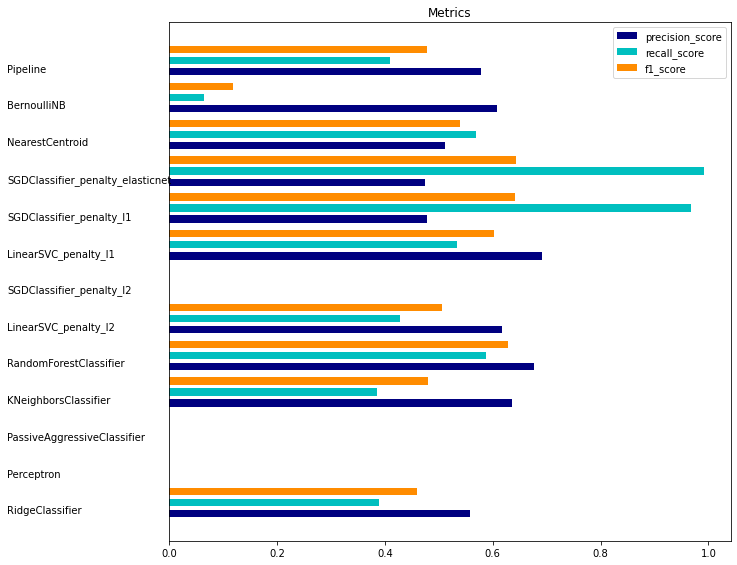

In [30]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(6)]

clf_names, precision_score, recall_score, f1_score, training_time, test_time = results
#training_time = np.array(training_time) / np.max(training_time)
#test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Metrics")
plt.barh(indices, precision_score, .2, label="precision_score", color='navy')
plt.barh(indices + .3, recall_score, .2, label="recall_score",
         color='c')
plt.barh(indices + .6, f1_score, .2, label="f1_score", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [31]:
df = pd.DataFrame()
df['Name'] = results[0]
df['Precision'] = results[1]
df['Recall'] = results[2]
df['F1_Score'] = results[3]
df['Training_time'] = results[4]
df['Test_time'] = results[5]

In [32]:
df

,Name,Precision,Recall,F1_Score,Training_time,Test_time
0,RidgeClassifier,0.557576,0.389831,0.458853,0.327572,0.001982
1,Perceptron,0.000000,0.000000,0.000000,0.098684,0.000839
2,PassiveAggressiveClassifier,0.000000,0.000000,0.000000,0.172712,0.001342
3,KNeighborsClassifier,0.636364,0.385593,0.480211,0.112948,0.158172
4,RandomForestClassifier,0.677262,0.586864,0.628831,5.837436,0.032144
5,LinearSVC_penalty_l2,0.617737,0.427966,0.505632,0.156776,0.006217
6,SGDClassifier_penalty_l2,0.000000,0.000000,0.000000,0.151263,0.001479
7,LinearSVC_penalty_l1,0.692308,0.533898,0.602871,1.107521,0.001139
8,SGDClassifier_penalty_l1,0.478534,0.968220,0.640505,0.251527,0.001020
9,SGDClassifier_penalty_elasticnet,0.475127,0.991525,0.642416,0.233404,0.001341


In [33]:
results_directory = "drive/My Drive/MTP/results/"

In [34]:
df.to_csv(results_directory + 'fastText_UNsupervised_CBOW_results.tsv', sep='\t')